# English Premier League -  Top 4 Prediction for 2017/18

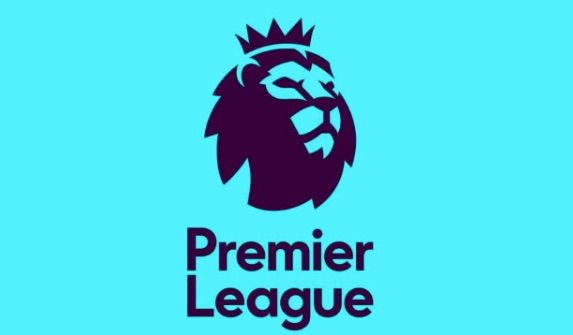

## Student Information
First Name: Hyunil  
Last Name: Yoo  
Student ID: 999252053

## The reason why I chose this topic.
1. A huge soccer and Chelsea FC fan 
2. Watch soccer every week
3. What are the most important factors to win a match?


## How I’m going to approach this topic?

1. Getting data from the official EPL website     
    a. Web scraping  
2. Exploring data  
    a. Data Cleaning  
    b. Visualizing data  
    c. Correlation among features  
3. Make statistical models  
    a. Multinomial Logistic Regression  
    b. Support Vector Machine  
    c. XG Boost  
    d. Knn
4. Choose the best model to predict the final table  

## Soccer Jargons  

Aerial Battle: The number of winning the balls that were in the air.  
Big Chance Created: The number of chances that are directly related to score.  
Clearance: The number of clearances in the defensive situations.  
Cross: The number of crosses that are executed.  
Cross Accuracy: The accuracy of cross that delivers the ball to the own team.  
Goal Conceded Per Match: Average conceding goals per match.  
Goal Per Match: Average scoring goals per match.  
Interception: The number of intercepts.  
Pass Accuracy: The accuracy of pass that delivers the ball to the own team.  
Pass Per Game: The number of passes that are executed.  
Shooting Accuracy: The accuracy of shooting that shots on goal.  
Shot On Target: The number of shootings on goal.  
Tackle Success: The accuracy of takle that successfully steals the ball from opponents.  

### Import Dependencies

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import random
from xgboost import XGBClassifier
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from pandas.tools.plotting import scatter_matrix
from time import time 
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from IPython.display import display

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# 1. Getting data from the official EPL website

## a. Web scraping

Using Scrapy attribution 'startproject' to organize the scrapying codes in the other folders. You can check the codes in crawler files.  
The codes below are the example of web scrapying of the standing tables for 2010 to 2018. I wrote the code in the py files and executed in the prompt command.

In [ ]:
import scrapy
import time
from selenium import webdriver
from selenium.webdriver.support.select import Select
from scrapy.selector import Selector
from test_crawler.items import TestItem

class TestItem(scrapy.Item):
    club_name = scrapy.Field()
    position = scrapy.Field()
    won = scrapy.Field()
    drawn = scrapy.Field()
    lost = scrapy.Field()
    goal = scrapy.Field()
    goal_against = scrapy.Field()
    points = scrapy.Field()

class TESTSpider(scrapy.Spider):
    name = "Test"
    allowed_domains = ["premierleague.com"]
    start_urls = [
        "https://www.premierleague.com/tables"
    ]
    
    def __init__(self):
        scrapy.Spider.__init__(self)
        self.browser = webdriver.Chrome("C:\sta\chromedriver.exe")
    
    def parse(self, response):
        self.browser.get(response.url)
        time.sleep(5)
#2017/18
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
        rows = selector.xpath('//*[@id="mainContent"]/div[2]/div[1]/div[3]/div/div/div/table/tbody/tr[not(@class="expandable")]')
        for row in rows:
            item = TestItem()
            item["club_name"] = row.xpath('./td[3]/a/span[2]/text()')[0].extract()
            item["position"] = row.xpath('./td[2]/span[1]/text()')[0].extract()
            item["won"] = row.xpath('./td[5]/text()')[0].extract()
            item["lost"] = row.xpath('./td[7]/text()')[0].extract()
            item["drawn"] = row.xpath('./td[6]/text()')[0].extract()
            item["goal"] = row.xpath('./td[8]/text()')[0].extract()
            item["goal_against"] = row.xpath('./td[9]/text()')[0].extract()
            item["points"] = row.xpath('./td[11]/text()')[0].extract()
            yield item
#2016/17
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/div[2]').click()
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/ul/li[2]').click()
        time.sleep(8)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
        
        rows = selector.xpath('//*[@id="mainContent"]/div[2]/div[1]/div[3]/div/div/div/table/tbody/tr[not(@class="expandable")]')
        for row in rows:
            item = TestItem()
            item["club_name"] = row.xpath('./td[3]/a/span[2]/text()')[0].extract()
            item["position"] = row.xpath('./td[2]/span[1]/text()')[0].extract()
            item["won"] = row.xpath('./td[5]/text()')[0].extract()
            item["lost"] = row.xpath('./td[7]/text()')[0].extract()
            item["drawn"] = row.xpath('./td[6]/text()')[0].extract()
            item["goal"] = row.xpath('./td[8]/text()')[0].extract()
            item["goal_against"] = row.xpath('./td[9]/text()')[0].extract()
            item["points"] = row.xpath('./td[11]/text()')[0].extract()
            yield item
#2015/16
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/div[2]').click()
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/ul/li[3]').click()
        time.sleep(8)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
        
        rows = selector.xpath('//*[@id="mainContent"]/div[2]/div[1]/div[3]/div/div/div/table/tbody/tr[not(@class="expandable")]')
        for row in rows:
            item = TestItem()
            item["club_name"] = row.xpath('./td[3]/a/span[2]/text()')[0].extract()
            item["position"] = row.xpath('./td[2]/span[1]/text()')[0].extract()
            item["won"] = row.xpath('./td[5]/text()')[0].extract()
            item["lost"] = row.xpath('./td[7]/text()')[0].extract()
            item["drawn"] = row.xpath('./td[6]/text()')[0].extract()
            item["goal"] = row.xpath('./td[8]/text()')[0].extract()
            item["goal_against"] = row.xpath('./td[9]/text()')[0].extract()
            item["points"] = row.xpath('./td[11]/text()')[0].extract()
            yield item
#2014/15
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/div[2]').click()
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/ul/li[4]').click()
        time.sleep(8)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
        
        rows = selector.xpath('//*[@id="mainContent"]/div[2]/div[1]/div[3]/div/div/div/table/tbody/tr[not(@class="expandable")]')
        for row in rows:
            item = TestItem()
            item["club_name"] = row.xpath('./td[3]/a/span[2]/text()')[0].extract()
            item["position"] = row.xpath('./td[2]/span[1]/text()')[0].extract()
            item["won"] = row.xpath('./td[5]/text()')[0].extract()
            item["lost"] = row.xpath('./td[7]/text()')[0].extract()
            item["drawn"] = row.xpath('./td[6]/text()')[0].extract()
            item["goal"] = row.xpath('./td[8]/text()')[0].extract()
            item["goal_against"] = row.xpath('./td[9]/text()')[0].extract()
            item["points"] = row.xpath('./td[11]/text()')[0].extract()
            yield item
#2013/14
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/div[2]').click()
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/ul/li[5]').click()
        time.sleep(8)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
        
        rows = selector.xpath('//*[@id="mainContent"]/div[2]/div[1]/div[3]/div/div/div/table/tbody/tr[not(@class="expandable")]')
        for row in rows:
            item = TestItem()
            item["club_name"] = row.xpath('./td[3]/a/span[2]/text()')[0].extract()
            item["position"] = row.xpath('./td[2]/span[1]/text()')[0].extract()
            item["won"] = row.xpath('./td[5]/text()')[0].extract()
            item["lost"] = row.xpath('./td[7]/text()')[0].extract()
            item["drawn"] = row.xpath('./td[6]/text()')[0].extract()
            item["goal"] = row.xpath('./td[8]/text()')[0].extract()
            item["goal_against"] = row.xpath('./td[9]/text()')[0].extract()
            item["points"] = row.xpath('./td[11]/text()')[0].extract()
            yield item
#2012/13
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/div[2]').click()
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/ul/li[6]').click()
        time.sleep(8)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
        
        rows = selector.xpath('//*[@id="mainContent"]/div[2]/div[1]/div[3]/div/div/div/table/tbody/tr[not(@class="expandable")]')
        for row in rows:
            item = TestItem()
            item["club_name"] = row.xpath('./td[3]/a/span[2]/text()')[0].extract()
            item["position"] = row.xpath('./td[2]/span[1]/text()')[0].extract()
            item["won"] = row.xpath('./td[5]/text()')[0].extract()
            item["lost"] = row.xpath('./td[7]/text()')[0].extract()
            item["drawn"] = row.xpath('./td[6]/text()')[0].extract()
            item["goal"] = row.xpath('./td[8]/text()')[0].extract()
            item["goal_against"] = row.xpath('./td[9]/text()')[0].extract()
            item["points"] = row.xpath('./td[11]/text()')[0].extract()
            yield item
#2011/12
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/div[2]').click()
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/ul/li[7]').click()
        time.sleep(8)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
        
        rows = selector.xpath('//*[@id="mainContent"]/div[2]/div[1]/div[3]/div/div/div/table/tbody/tr[not(@class="expandable")]')
        for row in rows:
            item = TestItem()
            item["club_name"] = row.xpath('./td[3]/a/span[2]/text()')[0].extract()
            item["position"] = row.xpath('./td[2]/span[1]/text()')[0].extract()
            item["won"] = row.xpath('./td[5]/text()')[0].extract()
            item["lost"] = row.xpath('./td[7]/text()')[0].extract()
            item["drawn"] = row.xpath('./td[6]/text()')[0].extract()
            item["goal"] = row.xpath('./td[8]/text()')[0].extract()
            item["goal_against"] = row.xpath('./td[9]/text()')[0].extract()
            item["points"] = row.xpath('./td[11]/text()')[0].extract()
            yield item
#2010/11
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/div[2]').click()
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/ul/li[8]').click()
        time.sleep(8)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
        
        rows = selector.xpath('//*[@id="mainContent"]/div[2]/div[1]/div[3]/div/div/div/table/tbody/tr[not(@class="expandable")]')
        for row in rows:
            item = TestItem()
            item["club_name"] = row.xpath('./td[3]/a/span[2]/text()')[0].extract()
            item["position"] = row.xpath('./td[2]/span[1]/text()')[0].extract()
            item["won"] = row.xpath('./td[5]/text()')[0].extract()
            item["lost"] = row.xpath('./td[7]/text()')[0].extract()
            item["drawn"] = row.xpath('./td[6]/text()')[0].extract()
            item["goal"] = row.xpath('./td[8]/text()')[0].extract()
            item["goal_against"] = row.xpath('./td[9]/text()')[0].extract()
            item["points"] = row.xpath('./td[11]/text()')[0].extract()
            yield item

# 2. Exploring data
## a. Data Cleaning

### Load the tables for 2010 to 2018

In [3]:
tables = pd.read_csv('C:\\sta\\sta141b-proj--hyunil-yoo\\test_crawler\\table.csv')
tables

,club_name,drawn,goal,goal_against,lost,points,position,won
0,Manchester City,3,83,20,1,78,1,25
1,Manchester United,5,58,23,5,65,2,20
2,Liverpool,9,68,34,4,60,3,17
3,Tottenham Hotspur,7,55,24,5,58,4,17
4,Chelsea,5,52,27,8,56,5,17
5,Arsenal,6,52,41,10,45,6,13
6,Burnley,10,27,26,9,43,7,11
7,Leicester City,10,45,43,10,40,8,10
8,Everton,7,35,49,13,37,9,10
9,Watford,6,39,47,13,36,10,10


### Checking the data types if there are values that are needed to be converted to either numeric or object values.

In [4]:
tables.dtypes

club_name       object
drawn            int64
goal             int64
goal_against     int64
lost             int64
points           int64
position         int64
won              int64
dtype: object

### Converting 'position' to object value

In [5]:
tables['position'] = tables['position'].astype(str)

### Since my interest is predicting top 4 on the table, I extract the top 4 teams thorught out 2010 to 2018.

In [6]:
top4_tables = tables[(tables['position'] == '1')|(tables['position'] == '2')| (tables['position'] == '3')|(tables['position'] == '4')]
top4_tables

,club_name,drawn,goal,goal_against,lost,points,position,won
0,Manchester City,3,83,20,1,78,1,25
1,Manchester United,5,58,23,5,65,2,20
2,Liverpool,9,68,34,4,60,3,17
3,Tottenham Hotspur,7,55,24,5,58,4,17
20,Chelsea,3,85,33,5,93,1,30
21,Tottenham Hotspur,8,86,26,4,86,2,26
22,Manchester City,9,80,39,6,78,3,23
23,Liverpool,10,78,42,6,76,4,22
40,Leicester City,12,68,36,3,81,1,23
41,Arsenal,11,65,36,7,71,2,20


### Here are the list of teams and the year that they were in the top 4 on the table
Manchester City: 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010  
Manchester United: 2017, 2014, 2012, 2011, 2010  
Arsenal: 2015, 2014, 2013, 2012, 2011, 2010  
Chelsea: 2016, 2014, 2013, 2012, 2010  
Liverpool: 2017, 2016, 2013   
Tottenham Hotspur: 2017, 2016, 2015, 2011  
Leicester City: 2015

### Here is another example of web scraping for each team's match statistics
Codes for getting Arsenal's match statistics

In [ ]:
import scrapy
import time
from selenium import webdriver
from selenium.webdriver.support.select import Select
from scrapy.selector import Selector
from clubstats_crawler.items import ClubItem

class ClubItem(scrapy.Item):
    club_name = scrapy.Field()
    goal_per_match = scrapy.Field()
    shot_on_target = scrapy.Field()
    shooting_accuracy = scrapy.Field()
    big_chance_created = scrapy.Field()
    pass_per_game = scrapy.Field()
    pass_accuracy = scrapy.Field()
    cross = scrapy.Field()
    cross_accuracy = scrapy.Field()
    goal_conceded_per_match = scrapy.Field()
    tackle_success = scrapy.Field()
    clearance = scrapy.Field()
    aerial_battles = scrapy.Field()
    interceptions = scrapy.Field()

class CLUBSpider(scrapy.Spider):
    name = "Clubstats"
    allowed_domains = ["premierleague.com"]
    start_urls = [
        "https://www.premierleague.com/clubs/1/Arsenal/stats?se=42"
    ]

    def __init__(self):
        scrapy.Spider.__init__(self)
        self.browser = webdriver.Chrome("C:\sta\chromedriver.exe")

    def parse(self, response):
        self.browser.get(response.url)
        time.sleep(5)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
# 2015/16
        item = ClubItem()
        item["club_name"] = selector.xpath('//*[@id="mainContent"]/header/div[2]/div/div/div[2]/h1/text()')[0].extract()
        item["goal_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[3]/span/span/text()')[0].extract()
        item["shot_on_target"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[5]/span/span/text()')[0].extract()
        item["shooting_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[6]/span/span/text()')[0].extract()
        item["big_chance_created"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[8]/span/span/text()')[0].extract()
        item["pass_per_game"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[3]/span/span/text()')[0].extract()
        item["pass_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[4]/span/span/text()')[0].extract()
        item["cross"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[5]/span/span/text()')[0].extract()
        item["cross_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[6]/span/span/text()')[0].extract()
        item["goal_conceded_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[4]/span/span/text()')[0].extract()
        item["tackle_success"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[7]/span/span/text()')[0].extract()
        item["clearance"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[10]/span/span/text()')[0].extract()
        item["aerial_battles"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[12]/span/span/text()')[0].extract()
        item["interceptions"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[9]/span/span/text()')[0].extract()
        yield item
# 2014/15
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/div[2]').click()
        time.sleep(3)
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/ul/li[5]').click()
        time.sleep(5)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)

        item = ClubItem()
        item["club_name"] = selector.xpath('//*[@id="mainContent"]/header/div[2]/div/div/div[2]/h1/text()')[0].extract()
        item["goal_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[3]/span/span/text()')[0].extract()
        item["shot_on_target"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[5]/span/span/text()')[0].extract()
        item["shooting_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[6]/span/span/text()')[0].extract()
        item["big_chance_created"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[8]/span/span/text()')[0].extract()
        item["pass_per_game"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[3]/span/span/text()')[0].extract()
        item["pass_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[4]/span/span/text()')[0].extract()
        item["cross"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[5]/span/span/text()')[0].extract()
        item["cross_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[6]/span/span/text()')[0].extract()
        item["goal_conceded_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[4]/span/span/text()')[0].extract()
        item["tackle_success"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[7]/span/span/text()')[0].extract()
        item["clearance"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[10]/span/span/text()')[0].extract()
        item["aerial_battles"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[12]/span/span/text()')[0].extract()
        item["interceptions"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[9]/span/span/text()')[0].extract()
        yield item
# 2013/14
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/div[2]').click()
        time.sleep(3)
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/ul/li[6]').click()
        time.sleep(5)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)

        item = ClubItem()
        item["club_name"] = selector.xpath('//*[@id="mainContent"]/header/div[2]/div/div/div[2]/h1/text()')[0].extract()
        item["goal_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[3]/span/span/text()')[0].extract()
        item["shot_on_target"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[5]/span/span/text()')[0].extract()
        item["shooting_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[6]/span/span/text()')[0].extract()
        item["big_chance_created"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[8]/span/span/text()')[0].extract()
        item["pass_per_game"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[3]/span/span/text()')[0].extract()
        item["pass_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[4]/span/span/text()')[0].extract()
        item["cross"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[5]/span/span/text()')[0].extract()
        item["cross_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[6]/span/span/text()')[0].extract()
        item["goal_conceded_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[4]/span/span/text()')[0].extract()
        item["tackle_success"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[7]/span/span/text()')[0].extract()
        item["clearance"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[10]/span/span/text()')[0].extract()
        item["aerial_battles"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[12]/span/span/text()')[0].extract()
        item["interceptions"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[9]/span/span/text()')[0].extract()
        yield item

# 2012/13
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/div[2]').click()
        time.sleep(3)
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/ul/li[7]]').click()
        time.sleep(5)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)

        item = ClubItem()
        item["club_name"] = selector.xpath('//*[@id="mainContent"]/header/div[2]/div/div/div[2]/h1/text()')[0].extract()
        item["goal_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[3]/span/span/text()')[0].extract()
        item["shot_on_target"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[5]/span/span/text()')[0].extract()
        item["shooting_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[6]/span/span/text()')[0].extract()
        item["big_chance_created"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[8]/span/span/text()')[0].extract()
        item["pass_per_game"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[3]/span/span/text()')[0].extract()
        item["pass_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[4]/span/span/text()')[0].extract()
        item["cross"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[5]/span/span/text()')[0].extract()
        item["cross_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[6]/span/span/text()')[0].extract()
        item["goal_conceded_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[4]/span/span/text()')[0].extract()
        item["tackle_success"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[7]/span/span/text()')[0].extract()
        item["clearance"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[10]/span/span/text()')[0].extract()
        item["aerial_battles"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[12]/span/span/text()')[0].extract()
        item["interceptions"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[9]/span/span/text()')[0].extract()
        yield item
# 2011/12
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/div[2]').click()
        time.sleep(3)
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/ul/li[8]').click()
        time.sleep(5)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)

        item = ClubItem()
        item["club_name"] = selector.xpath('//*[@id="mainContent"]/header/div[2]/div/div/div[2]/h1/text()')[0].extract()
        item["goal_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[3]/span/span/text()')[0].extract()
        item["shot_on_target"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[5]/span/span/text()')[0].extract()
        item["shooting_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[6]/span/span/text()')[0].extract()
        item["big_chance_created"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[8]/span/span/text()')[0].extract()
        item["pass_per_game"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[3]/span/span/text()')[0].extract()
        item["pass_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[4]/span/span/text()')[0].extract()
        item["cross"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[5]/span/span/text()')[0].extract()
        item["cross_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[6]/span/span/text()')[0].extract()
        item["goal_conceded_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[4]/span/span/text()')[0].extract()
        item["tackle_success"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[7]/span/span/text()')[0].extract()
        item["clearance"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[10]/span/span/text()')[0].extract()
        item["aerial_battles"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[12]/span/span/text()')[0].extract()
        item["interceptions"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[9]/span/span/text()')[0].extract()
        yield item
# 2010/11
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/div[2]').click()
        time.sleep(3)
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/ul/li[9]').click()
        time.sleep(5)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)

        item = ClubItem()
        item["club_name"] = selector.xpath('//*[@id="mainContent"]/header/div[2]/div/div/div[2]/h1/text()')[0].extract()
        item["goal_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[3]/span/span/text()')[0].extract()
        item["shot_on_target"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[5]/span/span/text()')[0].extract()
        item["shooting_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[6]/span/span/text()')[0].extract()
        item["big_chance_created"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[8]/span/span/text()')[0].extract()
        item["pass_per_game"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[3]/span/span/text()')[0].extract()
        item["pass_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[4]/span/span/text()')[0].extract()
        item["cross"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[5]/span/span/text()')[0].extract()
        item["cross_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[6]/span/span/text()')[0].extract()
        item["goal_conceded_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[4]/span/span/text()')[0].extract()
        item["tackle_success"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[7]/span/span/text()')[0].extract()
        item["clearance"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[10]/span/span/text()')[0].extract()
        item["aerial_battles"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[12]/span/span/text()')[0].extract()
        item["interceptions"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[9]/span/span/text()')[0].extract()
        yield item

### Load the match statistics files for each team

In [7]:
arsenal = pd.read_csv('C:\\sta\\sta141b-proj--hyunil-yoo\\clubstats_crawler\\arsenal.csv')
chelsea = pd.read_csv('C:\\sta\\sta141b-proj--hyunil-yoo\\clubstats_crawler\\chelsea.csv')
leicester = pd.read_csv('C:\\sta\\sta141b-proj--hyunil-yoo\\clubstats_crawler\\leicester.csv')
liverpool = pd.read_csv('C:\\sta\\sta141b-proj--hyunil-yoo\\clubstats_crawler\\liverpool.csv')
mancity = pd.read_csv('C:\\sta\\sta141b-proj--hyunil-yoo\\clubstats_crawler\\mancity.csv')
manutd = pd.read_csv('C:\\sta\\sta141b-proj--hyunil-yoo\\clubstats_crawler\\manutd.csv')
tottenham = pd.read_csv('C:\\sta\\sta141b-proj--hyunil-yoo\\clubstats_crawler\\tottenham.csv')

In [8]:
arsenal

,aerial_battles,big_chance_created,clearance,club_name,cross,cross_accuracy,goal_conceded_per_match,goal_per_match,interceptions,pass_accuracy,pass_per_game,shooting_accuracy,shot_on_target,tackle_success
0,"2,785",88,849,Arsenal,754,25%,0.95,1.71,734,84%,559.18,37%,211,73%
1,"3,242",66,"1,006",Arsenal,866,20%,0.95,1.87,762,84%,540.18,37%,227,75%
2,"2,777",62,"1,207",Arsenal,753,22%,1.08,1.79,541,86%,567.39,41%,213,74%
3,"2,840",70,873,Arsenal,951,19%,0.97,1.89,636,86%,555.53,34%,205,79%
4,"2,336",97,766,Arsenal,896,22%,1.29,1.95,605,85%,542.08,37%,236,74%
5,"2,636",99,"1,077",Arsenal,928,19%,1.13,1.89,709,84%,530.26,36%,238,74%


### The data need to be transformed so that it is easy to analyze and makes more precise prediction.

In [9]:
def data_clean(club):
    """Excluding non-numeric values such as comma and %"""
    club['cross_accuracy'] = club['cross_accuracy'].map(lambda x: x.rstrip('%'))
    club['pass_accuracy'] = club['pass_accuracy'].map(lambda x: x.rstrip('%'))
    club['shooting_accuracy'] = club['shooting_accuracy'].map(lambda x: x.rstrip('%')) 
    club['tackle_success'] = club['tackle_success'].map(lambda x: x.rstrip('%'))
    club['aerial_battles'] = club['aerial_battles'].str.replace(',','')
    club['clearance'] = club['clearance'].str.replace(',','')

In [10]:
data_clean(arsenal)
data_clean(chelsea)
data_clean(leicester)
data_clean(liverpool)
data_clean(mancity)
data_clean(manutd)
data_clean(tottenham)

In [11]:
manutd['cross'] = manutd['cross'].str.replace(',','')

In [12]:
manutd

,aerial_battles,big_chance_created,clearance,club_name,cross,cross_accuracy,goal_conceded_per_match,goal_per_match,interceptions,pass_accuracy,pass_per_game,shooting_accuracy,shot_on_target,tackle_success
0,2168,49,727,Manchester United,604,21,0.77,1.93,370,83,511.90,36,148,65
1,2689,54,1118,Manchester United,908,22,0.97,1.63,679,85,560.82,35,180,74
2,2477,89,1319,Manchester United,962,22,1.13,2.26,515,86,518.05,38,213,77
3,2151,85,1165,Manchester United,1018,22,0.87,2.34,574,85,531.16,38,243,75
4,2353,71,1053,Manchester United,1005,24,0.97,2.05,646,81,496.58,34,212,76


In [13]:
arsenal.dtypes

aerial_battles              object
big_chance_created           int64
clearance                   object
club_name                   object
cross                        int64
cross_accuracy              object
goal_conceded_per_match    float64
goal_per_match             float64
interceptions                int64
pass_accuracy               object
pass_per_game              float64
shooting_accuracy           object
shot_on_target               int64
tackle_success              object
dtype: object

In [14]:
def data_transform(club):
    """Transfor non-numeric value to numeric value"""
    club['cross_accuracy'] = pd.to_numeric(club['cross_accuracy']).astype(float)
    club['pass_accuracy'] = pd.to_numeric(club['pass_accuracy']).astype(float)
    club['shooting_accuracy'] = pd.to_numeric(club['shooting_accuracy']).astype(float)
    club['tackle_success'] = pd.to_numeric(club['tackle_success']).astype(float)
    club['aerial_battles'] = pd.to_numeric(club['aerial_battles']).astype(float)
    club['big_chance_created'] = club['big_chance_created'].astype(float)
    club['clearance'] = club['clearance'].astype(float)
    club['cross'] = club['cross'].astype(float)
    club['interceptions'] = club['interceptions'].astype(float)
    club['shot_on_target'] = club['shot_on_target'].astype(float)

In [15]:
data_transform(arsenal)
data_transform(chelsea)
data_transform(leicester)
data_transform(liverpool)
data_transform(mancity)
data_transform(manutd)
data_transform(tottenham)

In [16]:
arsenal

,aerial_battles,big_chance_created,clearance,club_name,cross,cross_accuracy,goal_conceded_per_match,goal_per_match,interceptions,pass_accuracy,pass_per_game,shooting_accuracy,shot_on_target,tackle_success
0,2785.0,88.0,849.0,Arsenal,754.0,25.0,0.95,1.71,734.0,84.0,559.18,37.0,211.0,73.0
1,3242.0,66.0,1006.0,Arsenal,866.0,20.0,0.95,1.87,762.0,84.0,540.18,37.0,227.0,75.0
2,2777.0,62.0,1207.0,Arsenal,753.0,22.0,1.08,1.79,541.0,86.0,567.39,41.0,213.0,74.0
3,2840.0,70.0,873.0,Arsenal,951.0,19.0,0.97,1.89,636.0,86.0,555.53,34.0,205.0,79.0
4,2336.0,97.0,766.0,Arsenal,896.0,22.0,1.29,1.95,605.0,85.0,542.08,37.0,236.0,74.0
5,2636.0,99.0,1077.0,Arsenal,928.0,19.0,1.13,1.89,709.0,84.0,530.26,36.0,238.0,74.0


### Some values are not in averaged. Since the values that I want to compare is the per match value, some values need to be averaged.

In [17]:
def average_wo2017(club):
    club['aerial_battles'] = club['aerial_battles'] / 38
    club['interceptions'] = club['interceptions'] / 38
    club['cross'] = club['cross'] / 38
    club['clearance'] = club['clearance'] / 38
    club['big_chance_created'] = club['big_chance_created'] / 38
    club['shot_on_target'] = club['shot_on_target'] / 38
    club['cross_accuracy'] = club['cross_accuracy'] / 100
    club['pass_accuracy'] = club['pass_accuracy'] / 100
    club['shooting_accuracy'] = club['shooting_accuracy'] / 100
    club['tackle_success'] = club['tackle_success'] / 100

def average_w2017(club):
    """
    Currently the teams only have played 29 matches; therefore, the current data need to 
    be divided by 29 not 38 which is the total matches of a year.
    """
    club['aerial_battles'].loc[0] = club['aerial_battles'].loc[0] / 29
    club['aerial_battles'].loc[1:] = club['aerial_battles'].loc[1:] / 38
    club['interceptions'].loc[0] = club['interceptions'].loc[0] / 29
    club['interceptions'].loc[1:] = club['interceptions'].loc[1:] / 38
    club['cross'].loc[0] = club['cross'].loc[0] / 29
    club['cross'].loc[1:] = club['cross'].loc[1:] / 38
    club['clearance'].loc[0] = club['clearance'].loc[0] / 29
    club['clearance'].loc[1:] = club['clearance'].loc[1:] / 38
    club['big_chance_created'].loc[0] = club['big_chance_created'].loc[0] / 29
    club['big_chance_created'].loc[1:] = club['big_chance_created'].loc[1:] / 38
    club['shot_on_target'].loc[0] = club['shot_on_target'].loc[0] / 29
    club['shot_on_target'].loc[1:] = club['shot_on_target'].loc[1:] / 38
    club['cross_accuracy'] = club['cross_accuracy'] / 100
    club['pass_accuracy'] = club['pass_accuracy'] / 100
    club['shooting_accuracy'] = club['shooting_accuracy'] / 100
    club['tackle_success'] = club['tackle_success'] / 100

In [18]:
average_wo2017(arsenal)
average_wo2017(chelsea)
average_wo2017(leicester)

In [19]:
average_w2017(liverpool)
average_w2017(mancity)
average_w2017(manutd)
average_w2017(tottenham)

### Rearrange the order of the column so that it's easlier to read the table.

In [20]:
def col_order(club):
    club_ordered = club[['club_name','goal_per_match', 'goal_conceded_per_match','shooting_accuracy',
          'shot_on_target', 'pass_accuracy', 'pass_per_game','cross', 'cross_accuracy',
          'interceptions', 'aerial_battles','big_chance_created', 'clearance', 'tackle_success']]
    return club_ordered

In [21]:
arsenal = col_order(arsenal)
chelsea = col_order(chelsea)
leicester = col_order(leicester)
liverpool = col_order(liverpool)
mancity = col_order(mancity)
manutd = col_order(manutd)
tottenham = col_order(tottenham)

In [22]:
arsenal

,club_name,goal_per_match,goal_conceded_per_match,shooting_accuracy,shot_on_target,pass_accuracy,pass_per_game,cross,cross_accuracy,interceptions,aerial_battles,big_chance_created,clearance,tackle_success
0,Arsenal,1.71,0.95,0.37,5.552632,0.84,559.18,19.842105,0.25,19.315789,73.289474,2.315789,22.342105,0.73
1,Arsenal,1.87,0.95,0.37,5.973684,0.84,540.18,22.789474,0.20,20.052632,85.315789,1.736842,26.473684,0.75
2,Arsenal,1.79,1.08,0.41,5.605263,0.86,567.39,19.815789,0.22,14.236842,73.078947,1.631579,31.763158,0.74
3,Arsenal,1.89,0.97,0.34,5.394737,0.86,555.53,25.026316,0.19,16.736842,74.736842,1.842105,22.973684,0.79
4,Arsenal,1.95,1.29,0.37,6.210526,0.85,542.08,23.578947,0.22,15.921053,61.473684,2.552632,20.157895,0.74
5,Arsenal,1.89,1.13,0.36,6.263158,0.84,530.26,24.421053,0.19,18.657895,69.368421,2.605263,28.342105,0.74


### Combined  'table' data frame with 'club statistis' dataframe for further analysis.

In [23]:
def final_stats(club):
    c_table = top4_tables[top4_tables['club_name'] == club['club_name'][0]]
    c_table = c_table.drop('club_name', axis=1)
    c_table['t'] = list(range(len(club))) # dummie column implies as a key column. 
    club['t'] = list(range(len(club)))
    result = club.merge(c_table, on=['t'])
    result = result.drop('t', axis=1) # drop the dummie column
    return result

In [24]:
pd.set_option('display.max_columns', 30)

In [25]:
arsenal = final_stats(arsenal)
chelsea = final_stats(chelsea)
leicester = final_stats(leicester)
liverpool = final_stats(liverpool)
mancity = final_stats(mancity)
manutd = final_stats(manutd)
tottenham = final_stats(tottenham)

In [26]:
chelsea

,club_name,goal_per_match,goal_conceded_per_match,shooting_accuracy,shot_on_target,pass_accuracy,pass_per_game,cross,cross_accuracy,interceptions,aerial_battles,big_chance_created,clearance,tackle_success,drawn,goal,goal_against,lost,points,position,won
0,Chelsea,2.24,0.87,0.35,5.368421,0.84,529.61,18.105263,0.19,13.421053,70.578947,1.263158,22.078947,0.71,3,85,33,5,93,1,30
1,Chelsea,1.92,0.84,0.37,5.526316,0.83,533.37,17.947368,0.22,9.894737,80.921053,1.736842,27.026316,0.81,9,73,32,3,87,1,26
2,Chelsea,1.87,0.71,0.33,6.026316,0.83,480.68,21.289474,0.25,10.000000,80.394737,1.315789,30.026316,0.77,7,71,27,6,82,3,25
3,Chelsea,1.97,1.03,0.34,5.578947,0.83,484.87,22.710526,0.20,13.263158,64.973684,1.473684,25.815789,0.76,9,75,39,7,75,3,22
4,Chelsea,1.82,0.87,0.33,6.421053,0.84,506.21,26.184211,0.25,16.210526,67.131579,2.263158,20.052632,0.74,8,69,33,9,71,2,21


In [27]:
a = [arsenal, chelsea, leicester, liverpool, mancity, manutd, tottenham]
all_data = arsenal.append([chelsea, leicester, liverpool, mancity, manutd, tottenham])
all_data

,club_name,goal_per_match,goal_conceded_per_match,shooting_accuracy,shot_on_target,pass_accuracy,pass_per_game,cross,cross_accuracy,interceptions,aerial_battles,big_chance_created,clearance,tackle_success,drawn,goal,goal_against,lost,points,position,won
0,Arsenal,1.71,0.95,0.37,5.552632,0.84,559.18,19.842105,0.25,19.315789,73.289474,2.315789,22.342105,0.73,11,65,36,7,71,2,20
1,Arsenal,1.87,0.95,0.37,5.973684,0.84,540.18,22.789474,0.20,20.052632,85.315789,1.736842,26.473684,0.75,9,71,36,7,75,3,22
2,Arsenal,1.79,1.08,0.41,5.605263,0.86,567.39,19.815789,0.22,14.236842,73.078947,1.631579,31.763158,0.74,7,68,41,7,79,4,24
3,Arsenal,1.89,0.97,0.34,5.394737,0.86,555.53,25.026316,0.19,16.736842,74.736842,1.842105,22.973684,0.79,10,72,37,7,73,4,21
4,Arsenal,1.95,1.29,0.37,6.210526,0.85,542.08,23.578947,0.22,15.921053,61.473684,2.552632,20.157895,0.74,7,74,49,10,70,3,21
5,Arsenal,1.89,1.13,0.36,6.263158,0.84,530.26,24.421053,0.19,18.657895,69.368421,2.605263,28.342105,0.74,11,72,43,8,68,4,19
0,Chelsea,2.24,0.87,0.35,5.368421,0.84,529.61,18.105263,0.19,13.421053,70.578947,1.263158,22.078947,0.71,3,85,33,5,93,1,30
1,Chelsea,1.92,0.84,0.37,5.526316,0.83,533.37,17.947368,0.22,9.894737,80.921053,1.736842,27.026316,0.81,9,73,32,3,87,1,26
2,Chelsea,1.87,0.71,0.33,6.026316,0.83,480.68,21.289474,0.25,10.000000,80.394737,1.315789,30.026316,0.77,7,71,27,6,82,3,25
3,Chelsea,1.97,1.03,0.34,5.578947,0.83,484.87,22.710526,0.20,13.263158,64.973684,1.473684,25.815789,0.76,9,75,39,7,75,3,22


### Since the dataset is not big, augment the data by using random sampling.

In [678]:
aug_dataset = all_data.sample(160, replace=True)
aug_dataset

,club_name,goal_per_match,goal_conceded_per_match,shooting_accuracy,shot_on_target,pass_accuracy,pass_per_game,cross,cross_accuracy,interceptions,aerial_battles,big_chance_created,clearance,tackle_success,drawn,goal,goal_against,lost,points,position,won
4,Manchester City,2.68,0.97,0.35,6.263158,0.86,546.34,23.473684,0.25,13.052632,67.421053,2.263158,24.684211,0.77,5,102,37,6,86,1,27
3,Manchester United,2.34,0.87,0.38,6.394737,0.85,531.16,26.789474,0.22,15.105263,56.605263,2.236842,30.657895,0.75,5,89,33,5,89,2,28
4,Manchester City,2.68,0.97,0.35,6.263158,0.86,546.34,23.473684,0.25,13.052632,67.421053,2.263158,24.684211,0.77,5,102,37,6,86,1,27
4,Manchester United,2.05,0.97,0.34,5.578947,0.81,496.58,26.447368,0.24,17.000000,61.921053,1.868421,27.710526,0.76,11,78,37,4,80,1,23
1,Manchester City,2.11,1.03,0.34,5.684211,0.86,597.53,21.078947,0.24,13.263158,71.842105,2.026316,23.815789,0.71,9,80,39,6,78,3,23
2,Arsenal,1.79,1.08,0.41,5.605263,0.86,567.39,19.815789,0.22,14.236842,73.078947,1.631579,31.763158,0.74,7,68,41,7,79,4,24
4,Manchester City,2.68,0.97,0.35,6.263158,0.86,546.34,23.473684,0.25,13.052632,67.421053,2.263158,24.684211,0.77,5,102,37,6,86,1,27
1,Tottenham Hotspur,2.26,0.68,0.38,6.763158,0.82,530.26,20.026316,0.20,8.263158,70.947368,1.394737,26.394737,0.75,8,86,26,4,86,2,26
0,Arsenal,1.71,0.95,0.37,5.552632,0.84,559.18,19.842105,0.25,19.315789,73.289474,2.315789,22.342105,0.73,11,65,36,7,71,2,20
4,Arsenal,1.95,1.29,0.37,6.210526,0.85,542.08,23.578947,0.22,15.921053,61.473684,2.552632,20.157895,0.74,7,74,49,10,70,3,21


### Make the data into the same scale, so that it produces better prediction.

In [679]:
data_x = aug_dataset.drop(['club_name', 'position'], axis= 1)
data_y = aug_dataset['position']

variables = [['won','points','goal_per_match', 'goal_conceded_per_match','shooting_accuracy','shot_on_target',
                       'pass_accuracy', 'pass_per_game','cross', 'cross_accuracy','interceptions', 'aerial_battles',
                       'big_chance_created', 'clearance', 'tackle_success', 'drawn', 'goal', 'lost']]

# Make every value in the same scale.
for variable in variables:
    data_x[variable] = scale(data_x[variable])

## b. Visualizing data & c. Correlation among features

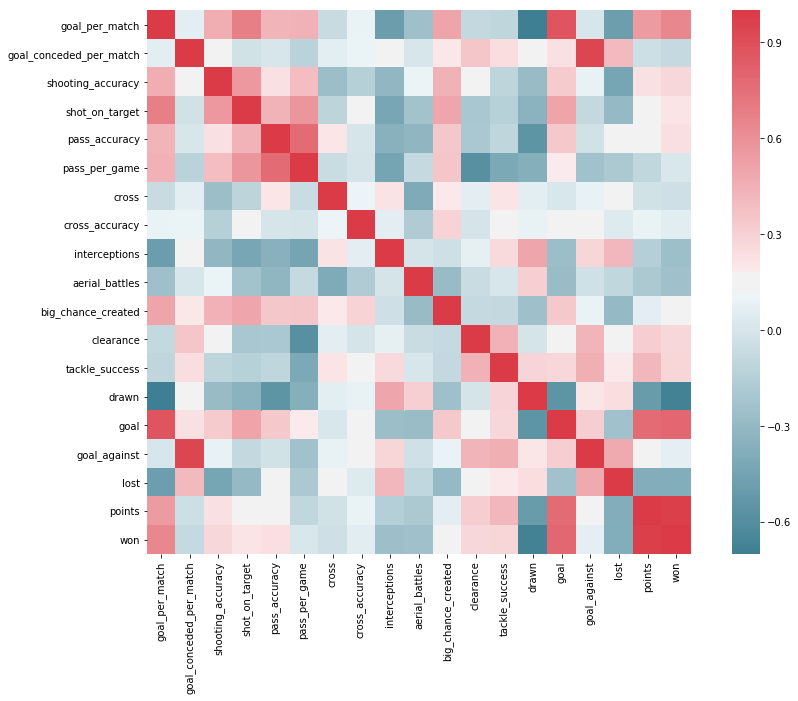

In [681]:
f, ax = plt.subplots(figsize=(15, 10))
corr = data_x.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [682]:
data_x.corr()

,goal_per_match,goal_conceded_per_match,shooting_accuracy,shot_on_target,pass_accuracy,pass_per_game,cross,cross_accuracy,interceptions,aerial_battles,big_chance_created,clearance,tackle_success,drawn,goal,goal_against,lost,points,won
goal_per_match,1.000000,0.062375,0.468732,0.675947,0.430561,0.447798,-0.064629,0.090642,-0.487713,-0.250824,0.506158,-0.083716,-0.096775,-0.699477,0.874782,0.009667,-0.483086,0.549042,0.643587
goal_conceded_per_match,0.062375,1.000000,0.162042,-0.021901,0.006886,-0.127552,0.057368,0.100452,0.161747,0.006165,0.200671,0.352930,0.249315,0.162799,0.235044,0.946699,0.403159,-0.041157,-0.076147
shooting_accuracy,0.468732,0.162042,1.000000,0.566160,0.232019,0.391713,-0.263170,-0.144703,-0.309151,0.103207,0.448357,0.118405,-0.104725,-0.286027,0.323679,0.084714,-0.439443,0.233376,0.270708
shot_on_target,0.675947,-0.021901,0.566160,1.000000,0.441347,0.576327,-0.111164,0.127539,-0.433714,-0.229269,0.496509,-0.202079,-0.141045,-0.344399,0.510928,-0.087126,-0.293700,0.151059,0.215488
pass_accuracy,0.430561,0.006886,0.232019,0.441347,1.000000,0.772829,0.204400,-0.000786,-0.360763,-0.316200,0.343566,-0.195558,-0.095689,-0.553111,0.341005,-0.019066,0.123350,0.117241,0.239506
pass_per_game,0.447798,-0.127552,0.391713,0.576327,0.772829,1.000000,-0.055950,-0.006833,-0.444716,-0.080608,0.355459,-0.574084,-0.412589,-0.361118,0.187508,-0.238300,-0.193028,-0.092048,0.013047
cross,-0.064629,0.057368,-0.263170,-0.111164,0.204400,-0.055950,1.000000,0.105149,0.221537,-0.394591,0.196373,0.069989,0.213848,0.061365,0.013976,0.090494,0.167146,-0.022223,-0.034406
cross_accuracy,0.090642,0.100452,-0.144703,0.127539,-0.000786,-0.006833,0.105149,1.000000,0.067333,-0.169194,0.291650,-0.005388,0.127798,0.087872,0.177693,0.141275,0.041110,0.092885,0.056747
interceptions,-0.487713,0.161747,-0.309151,-0.433714,-0.360763,-0.444716,0.221537,0.067333,1.000000,-0.007106,-0.031061,0.083141,0.260602,0.496447,-0.261591,0.278661,0.418183,-0.152284,-0.254970
aerial_battles,-0.250824,0.006165,0.103207,-0.229269,-0.316200,-0.080608,-0.394591,-0.169194,-0.007106,1.000000,-0.282875,-0.056083,0.010285,0.313126,-0.275466,-0.024439,-0.092865,-0.192288,-0.242631


After looking those plots above, we can find out that 'won' and 'point', which are directly related with winning the matches, are correlated with 'shooting accuracy', 'shot on target', 'clearance', 'tackle success', and 'goal'. And 'goal' is one of the important variables that helps to predict the winning, and it is correlated 'big chane created' As a result, the variables that affect winning are 'shooting accuray', 'shot on target', 'clearance', 'tackle success', 'goal', and 'big chane created'

On the other hand, 'lost' is correlated with 'cross', 'interception', 'goal against', goal conceded per match' and 'big change created'.

To sum up these observations, we can say that to win the match, it is important to have high values on 'shooting accuray' and 'shot on target', but also the team needs to have great performence on defense like 'clearance' and 'tackle success'. Based on the observation on 'lost', a team has higher chance of lose a game when a team tries to have many crosses and interceptions. This means a team is not focus on the shot on target but focus on the header. And interceptions happen when a team is defending;thus, higher number of interceptions might telling us that team is defending too much.

### Exploring the value of variables among  the 1st place to 4th place on the table

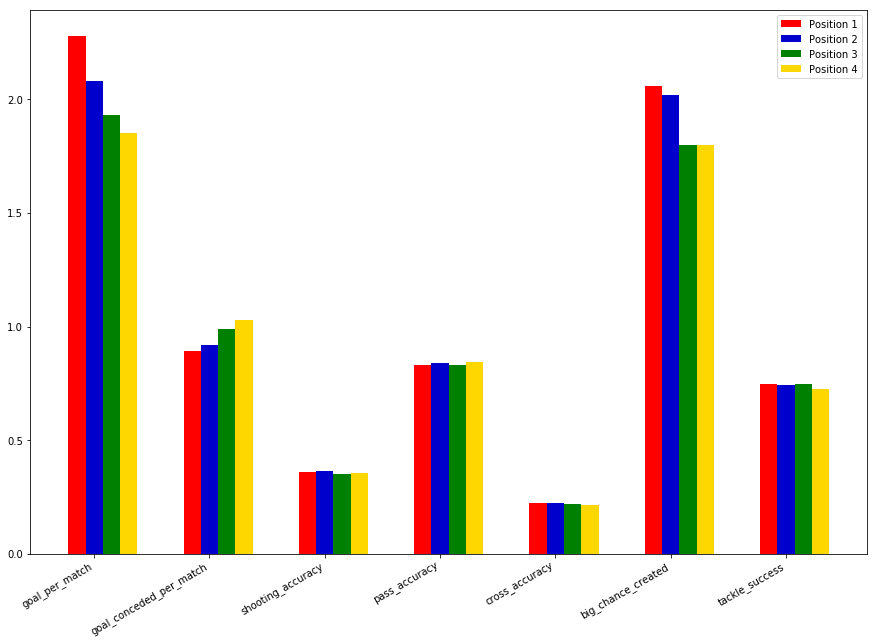

In [683]:
position_1 = all_data[all_data['position'] == '1']
position_1 = position_1[['goal_per_match', 'goal_conceded_per_match', 'shooting_accuracy', 
                         'pass_accuracy', 'cross_accuracy', 'big_chance_created', 'tackle_success']] 
position_1_mean = np.mean(position_1)

position_2 = all_data[all_data['position'] == '2']
position_2 = position_2[['goal_per_match', 'goal_conceded_per_match', 'shooting_accuracy', 
                         'pass_accuracy', 'cross_accuracy', 'big_chance_created', 'tackle_success']]
position_2_mean = np.mean(position_2)

position_3 = all_data[all_data['position'] == '3']
position_3 = position_3[['goal_per_match', 'goal_conceded_per_match', 'shooting_accuracy', 
                         'pass_accuracy', 'cross_accuracy', 'big_chance_created', 'tackle_success']]
position_3_mean = np.mean(position_3)

position_4 = all_data[all_data['position'] == '4']
position_4 = position_4[['goal_per_match', 'goal_conceded_per_match', 'shooting_accuracy', 
                         'pass_accuracy', 'cross_accuracy', 'big_chance_created', 'tackle_success']]
position_4_mean = np.mean(position_4)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

N= 7
ind = np.arange(N)
width = 0.15

p1 = ax.bar(ind, position_1_mean, width, color='red')
p2 = ax.bar(ind+width, position_2_mean, width, color='mediumblue')
p3 = ax.bar(ind+width*2, position_3_mean, width, color='green')
p4 = ax.bar(ind+width*3, position_4_mean, width, color='gold')

plt.xticks(ind, list(position_1))
ax.set_xticks(ind+width)
plt.xticks(rotation=30, ha='right')
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Position 1', 'Position 2', 'Position 3', 'Position 4'))

### There are big difference on 'goal per match', 'goal conceded per match', and 'big chance created'.

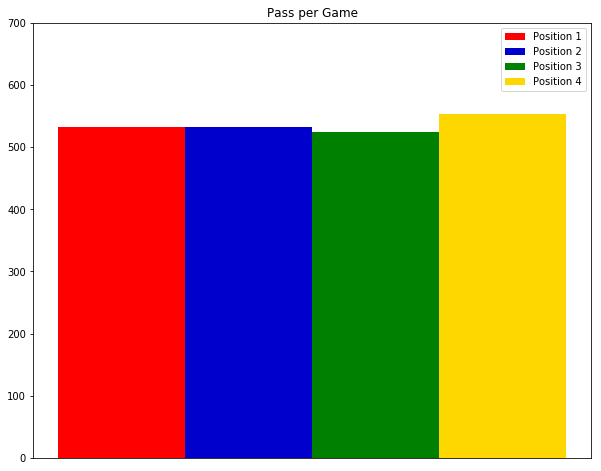

In [684]:
position_1 = all_data[all_data['position'] == '1']
position_1 = position_1['pass_per_game']
position_1_mean = np.mean(position_1)

position_2 = all_data[all_data['position'] == '2']
position_2 = position_2['pass_per_game']
position_2_mean = np.mean(position_2)

position_3 = all_data[all_data['position'] == '3']
position_3 = position_3['pass_per_game']
position_3_mean = np.mean(position_3)

position_4 = all_data[all_data['position'] == '4']
position_4 = position_4['pass_per_game']
position_4_mean = np.mean(position_4)

N= 1
ind = np.arange(N)
width = 0.39

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

p1 = ax.bar(ind, position_1_mean, width, color='red')
p2 = ax.bar(ind+width, position_2_mean, width, color='mediumblue')
p3 = ax.bar(ind+width*2, position_3_mean, width, color='green')
p4 = ax.bar(ind+width*3, position_4_mean, width, color='gold')

plt.title('Pass per Game')
plt.xticks(ind, " ")
ax.set_xticks(ind+width*100)
plt.xticks(rotation=30, ha='right')
plt.yticks(np.arange(0, 800, 100))
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Position 1', 'Position 2', 'Position 3', 'Position 4'))

### Based on the plot, 'pass per game' 'is not significantly related with get into higer place.

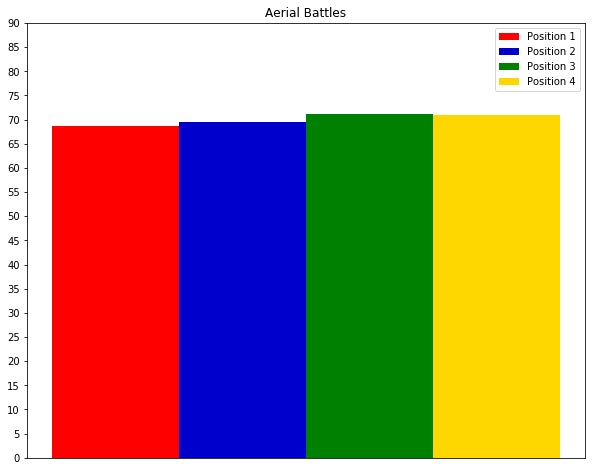

In [685]:
position_1 = all_data[all_data['position'] == '1']
position_1 = position_1['aerial_battles']
position_1_mean = np.mean(position_1)

position_2 = all_data[all_data['position'] == '2']
position_2 = position_2['aerial_battles']
position_2_mean = np.mean(position_2)

position_3 = all_data[all_data['position'] == '3']
position_3 = position_3['aerial_battles']
position_3_mean = np.mean(position_3)

position_4 = all_data[all_data['position'] == '4']
position_4 = position_4['aerial_battles']
position_4_mean = np.mean(position_4)

N= 1
ind = np.arange(N)
width = 0.39

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

p1 = ax.bar(ind, position_1_mean, width, color='red')
p2 = ax.bar(ind+width, position_2_mean, width, color='mediumblue')
p3 = ax.bar(ind+width*2, position_3_mean, width, color='green')
p4 = ax.bar(ind+width*3, position_4_mean, width, color='gold')

plt.title('Aerial Battles')
plt.xticks(ind, " ")
ax.set_xticks(ind+width*100)
plt.xticks(rotation=30, ha='right')
plt.yticks(np.arange(0, 95, 5))
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Position 1', 'Position 2', 'Position 3', 'Position 4'))

### The result is the same with the 'pass per game' it looks like it doesn't effect the game that much.

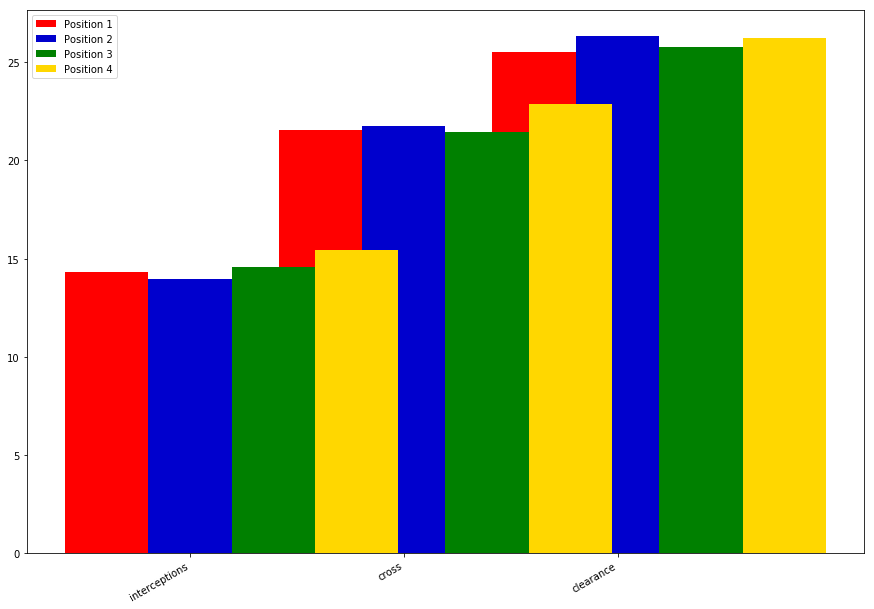

In [686]:
position_1 = all_data[all_data['position'] == '1']
position_1 = position_1[['interceptions', 'cross', 'clearance']]
position_1_mean = np.mean(position_1)

position_2 = all_data[all_data['position'] == '2']
position_2 = position_2[['interceptions', 'cross', 'clearance']]
position_2_mean = np.mean(position_2)

position_3 = all_data[all_data['position'] == '3']
position_3 = position_3[['interceptions', 'cross', 'clearance']]
position_3_mean = np.mean(position_3)

position_4 = all_data[all_data['position'] == '4']
position_4 = position_4[['interceptions', 'cross', 'clearance']]
position_4_mean = np.mean(position_4)

N= 3
ind = np.arange(N)
width = 0.39

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

p1 = ax.bar(ind, position_1_mean, width, color='red')
p2 = ax.bar(ind+width, position_2_mean, width, color='mediumblue')
p3 = ax.bar(ind+width*2, position_3_mean, width, color='green')
p4 = ax.bar(ind+width*3, position_4_mean, width, color='gold')

plt.xticks(ind, list(position_2))
ax.set_xticks(ind+width)
plt.xticks(rotation=30, ha='right')
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Position 1', 'Position 2', 'Position 3', 'Position 4'))

### Base on the plots above, we can say more the 'interceptions' and 'cross ' you have the lower the place you get on top4.

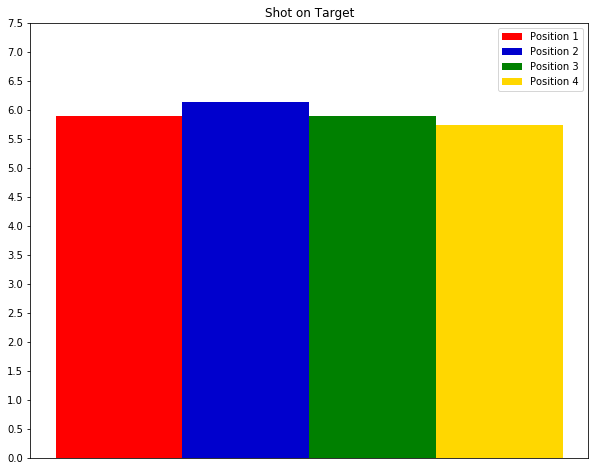

In [687]:
position_1 = all_data[all_data['position'] == '1']
position_1 = position_1['shot_on_target']
position_1_mean = np.mean(position_1)

position_2 = all_data[all_data['position'] == '2']
position_2 = position_2['shot_on_target']
position_2_mean = np.mean(position_2)

position_3 = all_data[all_data['position'] == '3']
position_3 = position_3['shot_on_target']
position_3_mean = np.mean(position_3)

position_4 = all_data[all_data['position'] == '4']
position_4 = position_4['shot_on_target']
position_4_mean = np.mean(position_4)

N= 1
ind = np.arange(N)
width = 0.39

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

p1 = ax.bar(ind, position_1_mean, width, color='red')
p2 = ax.bar(ind+width, position_2_mean, width, color='mediumblue')
p3 = ax.bar(ind+width*2, position_3_mean, width, color='green')
p4 = ax.bar(ind+width*3, position_4_mean, width, color='gold')

plt.title('Shot on Target')
plt.xticks(ind, " ")
ax.set_xticks(ind+width*100)
plt.xticks(rotation=30, ha='right')
plt.yticks(np.arange(0, 8, 0.5))
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Position 1', 'Position 2', 'Position 3', 'Position 4'))

### This show high 'Shot on Target' tend to lead higher place on the table.

# Make statistical models
a. Multinomial Logistic Regression  
b. Support Vector Machine  
c. XG boost  
d. Knn  

### According to the conclusions above, I choose 'goal_per_match', 'shooting_accuracy', 'shot_on_target', 'big_chance_created', and 'tackle_success' variables to make and test the statistical models. 

In [711]:
train_x, test_x, train_y, test_y = train_test_split(data_x[['goal_per_match', 'shooting_accuracy', 'shot_on_target',
                                                            'tackle_success', 'big_chance_created']], 
                                                    data_y, test_size = 16, random_state = 5, stratify = data_y)

In [712]:
logist_model = LogisticRegression(random_state = 100)
svc_model = SVC(random_state = 100, kernel='rbf')
xb_model = XGBClassifier()
knn_model = KNeighborsClassifier()

In [713]:
def model_test(model):
    y_pred = model.fit(train_x, train_y).predict(train_x)
    accuracy_score(y_pred, train_y)
    scores = cross_val_score(model, train_x, train_y, cv=2)
    print(scores.mean())

# 4. Choose the best model to predict the final table

In [714]:
model_test(svc_model)

0.861277252556


In [715]:
model_test(logist_model)

0.528651360216


In [716]:
model_test(xb_model)

0.88867451283


In [717]:
model_test(knn_model)

0.63881921667


### Based on the prediction above, XG boost model seems to be the best model. Therefore, XG boost model will be used in the final prediction.

### Getting the 2017/18 data for final prediction
1. current standing table
2. current club's match data

In [695]:
table2017 = pd.read_csv('C:\\sta\\sta141b-proj--hyunil-yoo\\epl_crawler\\table2017.csv')
table2017

,club_name,drawn,goal,goal_against,lost,points,position,won
0,Manchester City,3,83,20,1,78,1,25
1,Manchester United,5,56,22,5,62,2,19
2,Liverpool,9,67,32,3,60,3,17
3,Tottenham Hotspur,7,55,24,5,58,4,17
4,Chelsea,5,50,26,8,53,5,16
5,Arsenal,6,52,41,10,45,6,13
6,Burnley,10,24,26,9,40,7,10
7,Leicester City,10,41,42,10,37,8,9
8,Watford,6,39,47,13,36,9,10
9,Brighton and Hove Albion,10,28,38,11,34,10,8


### Bournemouth has to be changed as AFC Bournemouth because club's match data has it as AFC Bournemouth. Therefore, it has to be changed to join the data frame.

In [696]:
table2017 = table2017[['club_name', 'won', 'drawn', 'lost', 'goal', 'goal_against', 'points', 'position']]
table2017.iat[11,0] = 'AFC Bournemouth'
table2017

,club_name,won,drawn,lost,goal,goal_against,points,position
0,Manchester City,25,3,1,83,20,78,1
1,Manchester United,19,5,5,56,22,62,2
2,Liverpool,17,9,3,67,32,60,3
3,Tottenham Hotspur,17,7,5,55,24,58,4
4,Chelsea,16,5,8,50,26,53,5
5,Arsenal,13,6,10,52,41,45,6
6,Burnley,10,10,9,24,26,40,7
7,Leicester City,9,10,10,41,42,37,8
8,Watford,10,6,13,39,47,36,9
9,Brighton and Hove Albion,8,10,11,28,38,34,10


In [697]:
table2017['position'] = table2017['position'].astype(object)

In [698]:
stats2017 = pd.read_csv('C:\\sta\\sta141b-proj--hyunil-yoo\\club2017_crawler\\club_stats_2017.csv')

### Data have to be preprocessing to be analyzed.

In [699]:
stats2017

,aerial_battles,big_chance_created,clearance,club_name,cross,cross_accuracy,goal_conceded_per_match,goal_per_match,interceptions,pass_accuracy,pass_per_game,shooting_accuracy,shot_on_target,tackle_success
0,"2,061",60,616,Arsenal,438,21%,1.41,1.79,336,84%,629.52,38%,176,69%
1,"2,588",38,865,Stoke City,481,24%,1.86,0.97,361,73%,351.90,33%,104,66%
2,"2,357",28,811,West Ham United,574,21%,1.86,1.24,368,75%,373.79,38%,102,67%
3,"2,025",61,624,Tottenham Hotspur,651,20%,0.83,1.90,277,84%,576.62,33%,168,63%
4,"2,405",33,735,Watford,550,23%,1.62,1.34,359,76%,418.00,27%,95,64%
5,"2,114",34,681,Southampton,641,21%,1.41,1.00,355,79%,475.55,29%,104,70%
6,"2,219",27,756,West Bromwich Albion,608,24%,1.48,0.76,363,72%,345.72,30%,86,65%
7,"2,390",36,914,Newcastle United,456,21%,1.38,0.93,328,72%,356.93,34%,119,67%
8,"2,069",20,724,Swansea City,528,20%,1.45,0.86,298,78%,417.03,29%,72,68%
9,"2,142",27,976,Everton,459,24%,1.69,1.14,416,74%,386.41,33%,87,71%


In [700]:
def data_clean_2017(club):
    """Excluding non-numeric values such as comma and %"""
    club['cross_accuracy'] = club['cross_accuracy'].map(lambda x: x.rstrip('%'))
    club['pass_accuracy'] = club['pass_accuracy'].map(lambda x: x.rstrip('%'))
    club['shooting_accuracy'] = club['shooting_accuracy'].map(lambda x: x.rstrip('%')) 
    club['tackle_success'] = club['tackle_success'].map(lambda x: x.rstrip('%'))
    club['aerial_battles'] = club['aerial_battles'].str.replace(',','')

In [701]:
data_clean_2017(stats2017)
stats2017

,aerial_battles,big_chance_created,clearance,club_name,cross,cross_accuracy,goal_conceded_per_match,goal_per_match,interceptions,pass_accuracy,pass_per_game,shooting_accuracy,shot_on_target,tackle_success
0,2061,60,616,Arsenal,438,21,1.41,1.79,336,84,629.52,38,176,69
1,2588,38,865,Stoke City,481,24,1.86,0.97,361,73,351.90,33,104,66
2,2357,28,811,West Ham United,574,21,1.86,1.24,368,75,373.79,38,102,67
3,2025,61,624,Tottenham Hotspur,651,20,0.83,1.90,277,84,576.62,33,168,63
4,2405,33,735,Watford,550,23,1.62,1.34,359,76,418.00,27,95,64
5,2114,34,681,Southampton,641,21,1.41,1.00,355,79,475.55,29,104,70
6,2219,27,756,West Bromwich Albion,608,24,1.48,0.76,363,72,345.72,30,86,65
7,2390,36,914,Newcastle United,456,21,1.38,0.93,328,72,356.93,34,119,67
8,2069,20,724,Swansea City,528,20,1.45,0.86,298,78,417.03,29,72,68
9,2142,27,976,Everton,459,24,1.69,1.14,416,74,386.41,33,87,71


### Averaging the data that are not in average.

In [702]:
data_transform(stats2017)

def for_stats17(club):
    club['aerial_battles'] = club['aerial_battles'] / 29
    club['interceptions'] = club['interceptions'] / 29
    club['cross'] = club['cross'] / 29
    club['clearance'] = club['clearance'] / 29
    club['big_chance_created'] = club['big_chance_created'] / 29
    club['shot_on_target'] = club['shot_on_target'] / 29
    club['cross_accuracy'] = club['cross_accuracy'] / 100
    club['pass_accuracy'] = club['pass_accuracy'] / 100
    club['shooting_accuracy'] = club['shooting_accuracy'] / 100
    club['tackle_success'] = club['tackle_success'] / 100

In [703]:
for_stats17(stats2017)

In [704]:
col_order(stats2017)

,club_name,goal_per_match,goal_conceded_per_match,shooting_accuracy,shot_on_target,pass_accuracy,pass_per_game,cross,cross_accuracy,interceptions,aerial_battles,big_chance_created,clearance,tackle_success
0,Arsenal,1.79,1.41,0.38,6.068966,0.84,629.52,15.103448,0.21,11.586207,71.068966,2.068966,21.241379,0.69
1,Stoke City,0.97,1.86,0.33,3.586207,0.73,351.90,16.586207,0.24,12.448276,89.241379,1.310345,29.827586,0.66
2,West Ham United,1.24,1.86,0.38,3.517241,0.75,373.79,19.793103,0.21,12.689655,81.275862,0.965517,27.965517,0.67
3,Tottenham Hotspur,1.90,0.83,0.33,5.793103,0.84,576.62,22.448276,0.20,9.551724,69.827586,2.103448,21.517241,0.63
4,Watford,1.34,1.62,0.27,3.275862,0.76,418.00,18.965517,0.23,12.379310,82.931034,1.137931,25.344828,0.64
5,Southampton,1.00,1.41,0.29,3.586207,0.79,475.55,22.103448,0.21,12.241379,72.896552,1.172414,23.482759,0.70
6,West Bromwich Albion,0.76,1.48,0.30,2.965517,0.72,345.72,20.965517,0.24,12.517241,76.517241,0.931034,26.068966,0.65
7,Newcastle United,0.93,1.38,0.34,4.103448,0.72,356.93,15.724138,0.21,11.310345,82.413793,1.241379,31.517241,0.67
8,Swansea City,0.86,1.45,0.29,2.482759,0.78,417.03,18.206897,0.20,10.275862,71.344828,0.689655,24.965517,0.68
9,Everton,1.14,1.69,0.33,3.000000,0.74,386.41,15.827586,0.24,14.344828,73.862069,0.931034,33.655172,0.71


In [731]:
dataset = stats2017.join(table2017.set_index('club_name'), on = 'club_name')
dataset = dataset[['club_name', 'position','goal_per_match', 'goal_conceded_per_match', 'shooting_accuracy', 'shot_on_target', 'pass_accuracy', 
        'pass_per_game', 'cross', 'cross_accuracy', 'interceptions', 'aerial_battles', 'big_chance_created', 'clearance', 
        'tackle_success', 'drawn', 'goal', 'goal_against', 'lost', 'points', 'won']]

In [732]:
data_2017 = dataset.drop(['club_name', 'position'], axis= 1)


variables = [['won','points','goal_per_match', 'goal_conceded_per_match','shooting_accuracy','shot_on_target',
                       'pass_accuracy', 'pass_per_game','cross', 'cross_accuracy','interceptions', 'aerial_battles',
                       'big_chance_created', 'clearance', 'tackle_success', 'drawn', 'goal', 'lost']]
# Make every value in the same scale.
for variable in variables:
    data_2017[variable] = scale(data_2017[variable])

In [733]:
data_2017

,goal_per_match,goal_conceded_per_match,shooting_accuracy,shot_on_target,pass_accuracy,pass_per_game,cross,cross_accuracy,interceptions,aerial_battles,big_chance_created,clearance,tackle_success,drawn,goal,goal_against,lost,points,won
0,0.802257,0.179603,1.192079,1.385578,1.263924,1.634562,-1.919817,-0.274003,-0.033087,-0.772258,1.403408,-0.966056,0.940354,-0.803614,0.805845,41,-0.134396,0.372079,0.453025
1,-0.679389,1.452381,-0.132453,-0.455042,-0.908445,-0.940095,-1.153316,0.990627,0.557756,2.332090,-0.016131,0.973847,-0.371768,0.465250,-0.687613,54,0.843032,-0.856805,-0.841331
2,-0.191530,1.452381,1.192079,-0.506170,-0.513469,-0.737086,0.504464,-0.274003,0.723192,0.971361,-0.661376,0.553145,0.065606,0.465250,-0.189794,54,0.598675,-0.651991,-0.656423
3,1.001015,-1.460867,-0.132453,1.181064,1.263924,1.143966,1.877035,-0.695547,-1.427477,-0.984320,1.467933,-0.903730,-1.683890,-0.380659,0.992528,24,-1.356182,1.259606,1.192656
4,-0.010841,0.773566,-1.721892,-0.685120,-0.315981,-0.327081,0.076650,0.569084,0.510489,1.254110,-0.338754,-0.038954,-1.246516,-0.803614,-0.003111,47,0.598675,-0.242363,-0.101699
5,-0.625183,0.179603,-1.192079,-0.455042,0.276483,0.206639,1.698779,-0.274003,0.415954,-0.460056,-0.274229,-0.459656,1.377728,2.157070,-0.625386,41,0.109961,-0.788534,-1.026239
6,-1.058835,0.377591,-0.927173,-0.915197,-1.105934,-0.997408,1.110535,0.990627,0.605023,0.158457,-0.725901,0.124652,-0.809142,1.311160,-1.060978,43,1.087389,-1.334704,-1.396055
7,-0.751665,0.094751,0.132453,-0.071580,-1.105934,-0.893446,-1.598956,-0.274003,-0.222157,1.165751,-0.145180,1.355595,0.065606,0.042295,-0.749841,40,0.843032,-0.720262,-0.656423
8,-0.878147,0.292739,-1.192079,-1.273095,0.078995,-0.336077,-0.315513,-0.695547,-0.931169,-0.725133,-1.177573,-0.124652,0.502980,-0.803614,-0.874296,42,1.087389,-0.651991,-0.471515
9,-0.372219,0.971554,-0.132453,-0.889633,-0.710957,-0.620048,-1.545479,0.990627,1.857611,-0.295119,-0.725901,1.838623,1.815102,-0.380659,-0.376476,49,0.598675,-0.378906,-0.286607


In [734]:
p_position = xb_model.predict(data_2017[['goal_per_match', 'shooting_accuracy', 'shot_on_target',
                                         'tackle_success', 'big_chance_created']])

In [735]:
final_table= table2017.drop(['won', 'drawn', 'lost', 'goal', 'goal_against', 'points'],axis=1)

In [736]:
final_table['predicted position'] = p_position
final_table

,club_name,position,predicted position
0,Manchester City,1,2
1,Manchester United,2,4
2,Liverpool,3,3
3,Tottenham Hotspur,4,1
4,Chelsea,5,3
5,Arsenal,6,4
6,Burnley,7,4
7,Leicester City,8,3
8,Watford,9,3
9,Brighton and Hove Albion,10,1


### This is the final table that is predicted from the model. However, there are many teams that get high predicted position because the model that I made is based on the only top4 of the table; thus, I might exclude the variables that differenciate other positions that is below 4.

### Let see the prediction on the teams that was chosen from the beginning of the project.

In [737]:
final_table = final_table[(final_table['club_name'] == 'Manchester City') | (final_table['club_name'] == 'Manchester United')|
                          (final_table['club_name'] == 'Liverpool') | (final_table['club_name'] == 'Tottenham Hotspur')|
                          (final_table['club_name'] == 'Chelsea') | (final_table['club_name'] == 'Leicester City')]

In [738]:
final_table

,club_name,position,predicted position
0,Manchester City,1,2
1,Manchester United,2,4
2,Liverpool,3,3
3,Tottenham Hotspur,4,1
4,Chelsea,5,3
7,Leicester City,8,3


### Only Liverpool has the same position as a predicted position. And other predicted positions are pretty relevent with what is going on in real world. However, I cannot agree with Manchester City's predicted position is 2nd because they are currently crushing the league by a lot. If Manchester City want to end up with poision 2nd, they have to loss a lot of games which is very unlikely to happen. In my opinion, it is because data are all averaged. For example, if 'Team A' did poor in the beginning of the season and did exceptional great after few months, it is hard to distinguish with the 'Team B' that is not exceptional great but they are great enough to win the games. And this makes the different in the table because 'Team A' probably got many losts when they are in bad shape, but the 'Team B' wasn't. Therefore, the position in the table for 'Team A' and 'Team B' is totally different, but the average of the match statistics could be simliar. 

### In conclusion, the final prediction seems okay result but definitely not the best. The results from this analysis realize me that using the data that are averaged is not very effective for soccer predictions. The sequenced data would be much bettter because the teams have up and down moment like seasonality. Even after this class is over, I will strive to work on this more because as a soccer enthusiast this is very interesting work.